In [1]:
# model implementation
from ml.models.linear import LogisticRegression
from ml.algorithms.optimization import GradientDescent
from ml.models.statistical import GaussianDiscriminantAnalysis, GaussianNaiveBayes

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.classification import F1Score, BinaryAccuracy
from ml.stats import ClassificationStats

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

# sklearn models for comparison
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

np.random.seed(25)

## Q1, Q2 - Logistic Regression

### Load dataset

In [2]:
X, y = load_csv('./datasets/breastcancer.csv')
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

### Find best hyperparameters for Logistic Regression with grid search and k-fold with k=10

In [3]:
grid = GridSearchCV(stats_generator=ClassificationStats)

for lambda_reg in [0.01, 0.001]:
    for alpha_lr in [0.1, 0.01]:
        
        print(f"LR candidate {len(grid.candidates)}: learning rate={alpha_lr}, regularization={lambda_reg}")        
        
        grid.add(LogisticRegression, {
            "solver": GradientDescent(epochs=4000, learning_rate=alpha_lr, regularization=lambda_reg, metrics=F1Score()),
            "dataScaler": MinMaxScaler})

best = grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)

LR candidate 0: learning rate=0.1, regularization=0.01
LR candidate 1: learning rate=0.01, regularization=0.01
LR candidate 2: learning rate=0.1, regularization=0.001
LR candidate 3: learning rate=0.01, regularization=0.001


### Train Logistic Regresion with our best hyperparameters

Best candidate: 2 - Learning rate: 0.1 - Regularization term: 0.001


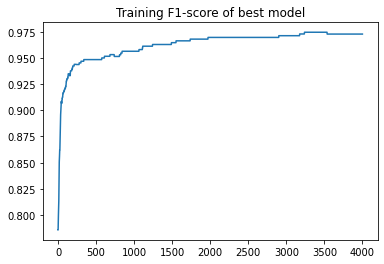

In [4]:
solver = grid.best_model_params['solver']
print("Best candidate:", grid.index_of_best, "- Learning rate:", solver.learning_rate, "- Regularization term:", solver.regularization)

model = grid.best_model(**grid.best_model_params)
training_score = model.fit(X_train, y_train)

plt.plot(training_score)
plt.title("Training F1-score of best model")
plt.show()

### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	0: 0.9639298321470211 +- 0.01947063335532256
	1: 0.9469387709279463 +- 0.026792111386639506
	2: 0.9692118011335614 +- 0.016551014340139864
	3: 0.9469949072026015 +- 0.028196226998961963
RECALL
	0: 0.9967741935483871 +- 0.009677419354838701
	1: 0.9937438905180841 +- 0.012519853487065769
	2: 0.9967741935483871 +- 0.009677419354838701
	3: 0.9907135874877809 +- 0.01962473626584892
PRECISION
	0: 0.9337309035050969 +- 0.03371231782134512
	1: 0.9055180584160496 +- 0.04661791284900518
	2: 0.9436052918881062 +- 0.02947563006528015
	3: 0.9082767102638855 +- 0.0473146703450143
BINARY_ACCURACY
	0: 0.9538647342995169 +- 0.02491016321538867
	1: 0.9318357487922706 +- 0.03185289796367019
	2: 0.9604830917874396 +- 0.021482978265458107
	3: 0.9318357487922706 +- 0.034693558847546636


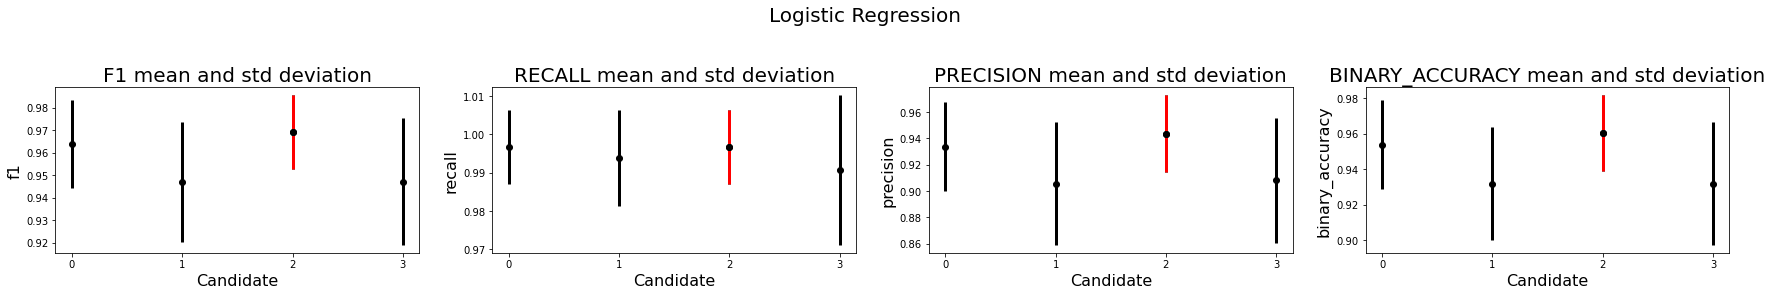

In [5]:
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Logistic Regression", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=np.arange(num_candidates))
    plt.xlabel("Candidate", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    candidates = np.arange(num_candidates)
    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])
    
    k+=1

## Q1,Q2 - Gaussian Discriminant Analysis

### Load dataset

In [6]:
X, y = load_csv('./datasets/breastcancer.csv')

y = y.astype(int).squeeze() # required by our GDA as well as sklearn's
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

### Leverage our Grid Search with Cross-Validation class to run K-fold with k=10

In [7]:
grid_gda = GridSearchCV(stats_generator=ClassificationStats)

grid_gda.add(GaussianDiscriminantAnalysis, {})
grid_gda.add(QuadraticDiscriminantAnalysis, {}) # sklearn's implementation for comparison

grid_gda.search(X_train, y_train, num_folds=10, score=BinaryAccuracy(), score_minimize=False, shuffle=False)

(ml.models.statistical.GaussianDiscriminantAnalysis, {})

### Train GDA and present its performance on the test dataset

In [8]:
gda = GaussianDiscriminantAnalysis()
gda.fit(X_train, y_train)

print("F1-score:", F1Score().measure(y_test, gda.predict(X_test)))
print("Accuracy:", BinaryAccuracy().measure(y_test, gda.predict(X_test)))

F1-score: 0.9710144927536232
Accuracy: 0.9649122807017544


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	Ours: 0.9613140627409702 +- 0.021213961612380986
	Sklearn's: 0.9613140627409702 +- 0.021213961612380986
RECALL
	Ours: 0.9576522315076265 +- 0.029459191263803853
	Sklearn's: 0.9576522315076265 +- 0.029459191263803853
PRECISION
	Ours: 0.9656843667085603 +- 0.02614567794247916
	Sklearn's: 0.9656843667085603 +- 0.02614567794247916
BINARY_ACCURACY
	Ours: 0.9515458937198067 +- 0.02779104912961896
	Sklearn's: 0.9515458937198067 +- 0.02779104912961896


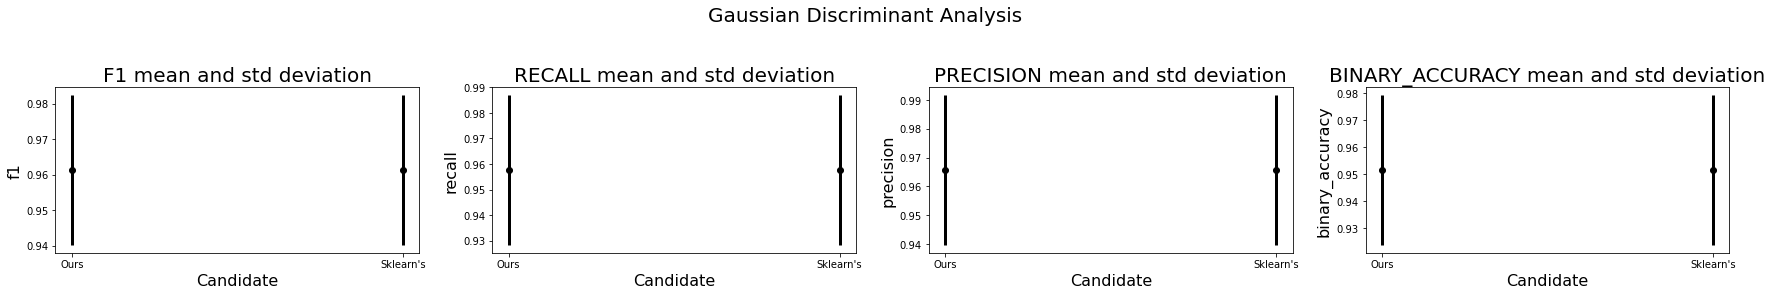

In [9]:
num_candidates = len(grid_gda.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Gaussian Discriminant Analysis", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid_gda.stats[i].stats["values"][metric]))
        std.append(np.std(grid_gda.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=["Ours", "Sklearn's"])
    plt.xlabel("Candidate", fontsize=16)
    plt.ylabel(metric, fontsize=16)
    
    k+=1

    candidates = ["Ours", "Sklearn's"]
    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])

## Q1,Q2 - Gaussian Naive Bayes
### Load dataset

In [10]:
X, y = load_csv('./datasets/breastcancer.csv')

y = y.astype(int).squeeze() # required by our GDA as well as sklearn's
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

### Leverage our Grid Search with Cross-Validation class to run K-fold with k=10

In [11]:
grid_gnb = GridSearchCV(stats_generator=ClassificationStats)

grid_gnb.add(GaussianNaiveBayes, {})
grid_gnb.add(GaussianNB, {}) # sklearn's implementation for comparison

grid_gnb.search(X_train, y_train, num_folds=10, score=BinaryAccuracy(), score_minimize=False, shuffle=False)

(sklearn.naive_bayes.GaussianNB, {})

### Train GNB and present its performance on the test dataset

In [12]:
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

print("F1-score:", F1Score().measure(y_test, gnb.predict(X_test)))
print("Accuracy:", BinaryAccuracy().measure(y_test, gnb.predict(X_test)))

F1-score: 0.9710144927536232
Accuracy: 0.9649122807017544


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	Ours: 0.9398262458234619 +- 0.024719633408554813
	Sklearn's: 0.9468579047449281 +- 0.03295112836833744
RECALL
	Ours: 0.9497436025022232 +- 0.03497589390572195
	Sklearn's: 0.9636598586598588 +- 0.03809500477840305
PRECISION
	Ours: 0.9321113474339281 +- 0.043036054844836184
	Sklearn's: 0.93291991914072 +- 0.05218545565034877
BINARY_ACCURACY
	Ours: 0.9233333333333335 +- 0.033723163322827855
	Sklearn's: 0.9321739130434782 +- 0.042859363221506144


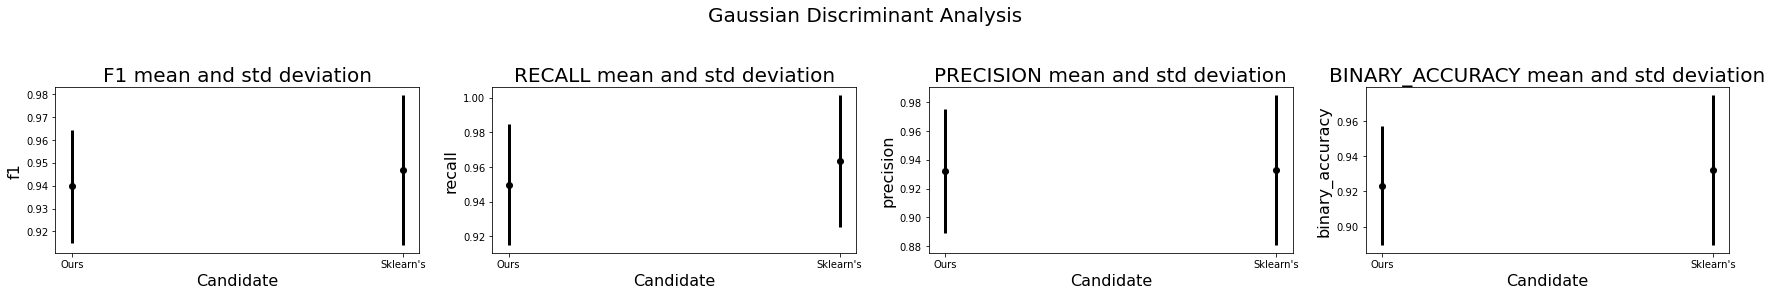

In [13]:
num_candidates = len(grid_gnb.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Gaussian Discriminant Analysis", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid_gnb.stats[i].stats["values"][metric]))
        std.append(np.std(grid_gnb.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=["Ours", "Sklearn's"])
    plt.xlabel("Candidate", fontsize=16)
    plt.ylabel(metric, fontsize=16)
    
    k+=1
    
    candidates = ["Ours", "Sklearn's"]
    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])